<a href="https://colab.research.google.com/github/augustmuso/portfolios/blob/main/Python_for_Finance_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import some libs

from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing


<!-- using FAANG as investment choices
 -->

Let's now get the cumulative return for 2018, which is also known as normalizing a price.

We're going to create a new column in each stock dataframe called Normed Return.

In [2]:
# seleect universe
# assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
# assets = ['SPY', 'GLD', 'AAPL', 'FXB', 'TLT']
assets = ['AAPL', 'MSFT', 'SQ']



# assigning the weights
weights = np.array([ 0.2, 0.2 , 0.2])

# start date
stockstartdate = '2016-01-01'

# end date
today = datetime.today().strftime('%Y-%m-%d')

# geting the stock data
df = pd.DataFrame()

for stock in assets:
  df[stock] = web.DataReader(stock, 
                             data_source = 'yahoo',
                             start = stockstartdate, 
                             end = today )['Adj Close']

In [3]:
df.head()

,AAPL,MSFT,SQ
Date,,,
2016-01-04,24.323219,49.776890,12.16
2016-01-05,23.713696,50.003983,11.51
2016-01-06,23.249626,49.095642,11.52
2016-01-07,22.268383,47.387970,11.16
2016-01-08,22.386133,47.533310,11.31


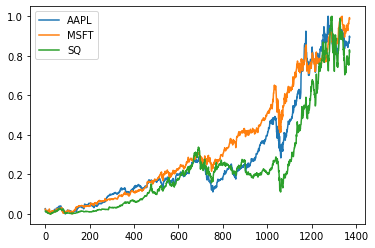

In [4]:
min_max = preprocessing.MinMaxScaler()
scaled_df = min_max.fit_transform(df.values)
final_df = pd.DataFrame(scaled_df,columns=assets)
final_df.plot()


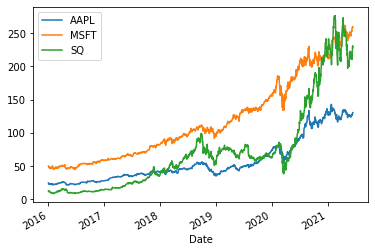

In [5]:
# view graph
df.plot()

In [6]:
# show daily returns
returns = df.pct_change()

# annual cov mat
cov_mat_anual = returns.cov() * 252

# get portifolio varience
port_varience = np.dot(weights.T , np.dot(cov_mat_anual, weights))

print(port_varience)

#  get volatility aka risk aka std
port_volatility = np.sqrt(port_varience)

print(port_volatility)

# portifolio anual return 
PAR = np.sum(returns.mean()*weights) * 252

print(PAR)

report = 'risk of '+ str(np.round(port_volatility, 3) * 100) + '% and reward of '+ str(np.round(PAR, 3) * 100)+ '%'
print(report)

0.035845453550969006
0.18932895592319998
0.27674655609105286
risk of 18.9% and reward of 27.700000000000003%


In [7]:
pip install pyportfolioopt

     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 1.3MB 34.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736205 sha256=344751d38ae0690d669a465376dd7a29080057b6d475627e914cc35c9f8c443d
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [8]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [9]:
# portifolio Optimization !

# get the expected return and anual covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#  optim the sharpe raatio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_wieghts = ef.clean_weights()
print(cleaned_wieghts)

ef.portfolio_performance(verbose = True)


OrderedDict([('AAPL', 0.27412), ('MSFT', 0.39911), ('SQ', 0.32677)])
Expected annual return: 47.3%
Annual volatility: 31.3%
Sharpe Ratio: 1.45


(0.47327408385083264, 0.31333464738980166, 1.446613349742138)

In [10]:
# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_wieghts

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 1000)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))

discret allocation:  {'AAPL': 2, 'MSFT': 1, 'SQ': 2}
funds remaining: $25.66


***try different solvers***




In [11]:
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import plotting

In [ ]:
views = np.array([-0.20, 0.10, 0.15]).reshape(-1, 1)
picking = np.array(
    [
        [ 0, 0, 0, 0, 1],
        [1, 0, -1, 0, 0],
        [ 0, -0.5, 0.5, 0, -0.5],
    ]
)

delta = black_litterman.market_implied_risk_aversion(spy_prices)

mcaps = {
    "FB": 574e9,
    "AMZN": 867e9,
    "AAPL": 1.19e12,
    "NFLX": 102e9,
    "GOOG": 927e9
}
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
bl = BlackLittermanModel(S, Q=views, P=picking, pi=prior, tau=0.01)
rets = bl.bl_returns()
ef = EfficientFrontier(rets, S)
ef.max_sharpe()
print(ef.clean_weights())
ef.portfolio_performance(verbose=True)

/usr/local/lib/python3.7/dist-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


OptimizationError: ignored

Expected annual return: 41.2%
Annual volatility: 28.5%
Sharpe Ratio: 1.38
OrderedDict([('AAPL', 0.3669153707660805), ('MSFT', 0.4418208437045993), ('SQ', 0.19126378552932022)])
discret allocation:  {'AAPL': 42, 'MSFT': 26, 'SQ': 12}
funds remaining: $88.64


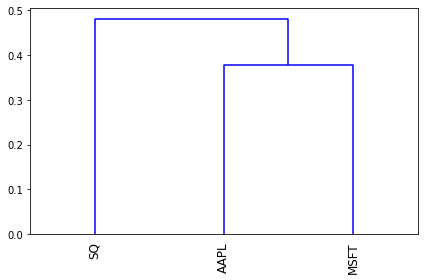

In [12]:
# Hierarchical risk parity
hrp = HRPOpt(returns)
weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(weights)
plotting.plot_dendrogram(hrp)  # to plot dendrogram

# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))

OrderedDict([('AAPL', 0.2788690054191775), ('MSFT', 0.4165618134685801), ('SQ', 0.3045691811122429)])
Expected annual return: 46.5%
Annual volatility: 30.8%
Sharpe Ratio: 1.45
discret allocation:  {'AAPL': 32, 'MSFT': 24, 'SQ': 20}
funds remaining: $79.84


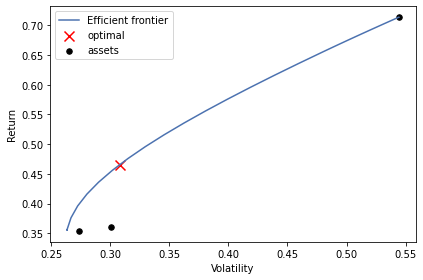

In [13]:
# Crticial Line Algorithm
cla = CLA(mu, S)
weights = cla.max_sharpe()
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))